# 3. About vanishing gradients

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.0 (17/12/2022)

**Requirements:**
- Python 3 (tested on v3.9.6)
- Matplotlib (tested on v3.5.1)
- Numpy (tested on v1.22.1)

### Imports

In [1]:
# Matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
# Numpy
import numpy as np
# Removing unecessary warnings (optional, just makes notebook outputs more readable)
import warnings
warnings.filterwarnings("ignore")

### Blast from the past - Mock dataset generation

As in previous notebook.

In [2]:
# All helper functions
min_surf = 40
max_surf = 200
def surface(min_surf, max_surf):
    return round(np.random.uniform(min_surf, max_surf), 2)
min_dist = 50
max_dist = 1000
def distance(min_dist, max_dist):
    return round(np.random.uniform(min_dist, max_dist), 2)
def price(surface, distance):
    return round((100000 + 14373*surface + (1000 - distance)*1286)*(1 + np.random.uniform(-0.1, 0.1)))/1000000
n_points = 100
def create_dataset(n_points, min_surf, max_surf, min_dist, max_dist):
    surfaces_list = np.array([surface(min_surf, max_surf) for _ in range(n_points)])
    distances_list = np.array([distance(min_dist, max_dist) for _ in range(n_points)])
    inputs = np.array([[s, d] for s, d in zip(surfaces_list, distances_list)])
    outputs = np.array([price(s, d) for s, d in zip(surfaces_list, distances_list)]).reshape(n_points, 1)
    return surfaces_list, distances_list, inputs, outputs

In [3]:
# Generate dataset
np.random.seed(47)
surfaces_list, distances_list, inputs, outputs = create_dataset(n_points, min_surf, max_surf, min_dist, max_dist)
# Check a few entries of the dataset
print(surfaces_list.shape)
print(distances_list.shape)
print(inputs.shape)
print(outputs.shape)
print(inputs[0:10, :])
print(outputs[0:10])

(100,)
(100,)
(100, 2)
(100, 1)
[[ 58.16 572.97]
 [195.92 809.8 ]
 [156.6  349.04]
 [ 96.23  86.82]
 [153.22 817.92]
 [167.94 806.25]
 [143.29 315.92]
 [106.34 482.67]
 [152.96 427.77]
 [ 79.46 955.76]]
[[1.581913]
 [3.450274]
 [2.978769]
 [2.808258]
 [2.556398]
 [3.023983]
 [3.099523]
 [2.121069]
 [3.136544]
 [1.273443]]


### ShallowNeuralNet class with intializations

As in previous notebook.

In [4]:
class ShallowNeuralNet():
    
    def __init__(self, n_x, n_h, n_y, init_type = "Normal"):
        # Network dimensions
        self.n_x = n_x
        self.n_h = n_h
        self.n_y = n_y
        # Initialize parameters
        self.init_type = init_type
        self.init_parameters()
        # Loss, initialized as infinity before first calculation is made
        self.loss = float("Inf")
        
    def init_parameters(self):
        if(self.init_type == "Normal"):
            self.init_parameters_normal()
        elif(self.init_type == "Xavier"):
            self.init_parameters_xavier()
        elif(self.init_type == "He"):
            self.init_parameters_he()
        elif(self.init_type == "LeCun"):
            self.init_parameters_lecun()
        elif(self.init_type == "Constant"):
            self.init_parameters_const()
        elif(self.init_type == "Zero"):
            self.init_parameters_zero()
        else:
            assert False, "Invalid initialization of parameters, check your init_type."
            
    def init_parameters_normal(self):
        # Weights and biases matrices (randomly initialized)
        self.W1 = np.random.randn(self.n_x, self.n_h)*0.1
        self.b1 = np.random.randn(1, self.n_h)*0.1
        self.W2 = np.random.randn(self.n_h, self.n_y)*0.1
        self.b2 = np.random.randn(1, self.n_y)*0.1
        
    def init_parameters_xavier(self):
        # Weights and biases matrices (Xavier initialized)
        init_val = np.sqrt(6.0/(self.n_x + self.n_y))
        self.W1 = np.random.uniform(-init_val, init_val, (self.n_x, self.n_h))
        self.b1 = np.random.uniform(-init_val, init_val, (1, self.n_h))
        self.W2 = np.random.uniform(-init_val, init_val, (self.n_h, self.n_y))
        self.b2 = np.random.uniform(-init_val, init_val, (1, self.n_y))
        
    def init_parameters_he(self):
        # Weights and biases matrices (He initialized)
        range1 = np.sqrt(2/self.n_x)
        self.W1 = np.random.randn(self.n_x, self.n_h)*range1
        self.b1 = np.zeros((1, self.n_h))
        range2 = np.sqrt(2/self.n_h)
        self.W2 = np.random.randn(self.n_h, self.n_y)*range2
        self.b2 = np.zeros((1, self.n_y))
        
    def init_parameters_lecun(self):
        # Weights and biases matrices (LeCun initialized)
        range1 = np.sqrt(1/self.n_x)
        self.W1 = np.random.randn(self.n_x, self.n_h)*range1
        self.b1 = np.zeros((1, self.n_h))
        range2 = np.sqrt(1/self.n_h)
        self.W2 = np.random.randn(self.n_h, self.n_y)*range2
        self.b2 = np.zeros((1, self.n_y))
        
    def init_parameters_const(self):
        # Weights and biases matrices (Constant initialized)
        const_val = 0.1
        self.W1 = np.ones(shape = (n_x, n_h))*const_val
        self.b1 = np.ones(shape = (1, n_h))*const_val
        self.W2 = np.ones(shape = (n_h, n_y))*const_val
        self.b2 = np.ones(shape = (1, n_y))*const_val
        
    def init_parameters_zero(self):
        # Weights and biases matrices (Zero initialized)
        self.W1 = np.zeros(shape = (n_x, n_h))
        self.b1 = np.zeros(shape = (1, n_h))
        self.W2 = np.zeros(shape = (n_h, n_y))
        self.b2 = np.zeros(shape = (1, n_y))
        
    def forward(self, inputs):
        # Wx + b operation for the first layer
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        # Wx + b operation for the second layer
        Z2 = np.matmul(Z1_b, self.W2)
        Z2_b = Z2 + self.b2
        return Z2_b
    
    def MSE_loss(self, inputs, outputs):
        # MSE loss function as before
        outputs_re = outputs.reshape(-1, 1)
        pred = self.forward(inputs)
        losses = (pred - outputs_re)**2
        self.loss = np.sum(losses)/outputs.shape[0]
        return self.loss
    
    def backward(self, inputs, outputs, alpha = 1e-5):
        # Get the number of samples in dataset
        m = inputs.shape[0]
        
        # Forward propagate
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        Z2 = np.matmul(Z1_b, self.W2)
        y_pred = Z2 + self.b2
    
        # Compute error term
        epsilon = y_pred - outputs
    
        # Compute the gradient for W2 and b2
        dL_dW2 = (2/m)*np.matmul(Z1_b.T, epsilon)
        dL_db2 = (2/m)*np.sum(epsilon, axis = 0, keepdims = True)

        # Compute the loss derivative with respect to the first layer
        dL_dZ1 = np.matmul(epsilon, self.W2.T)

        # Compute the gradient for W1 and b1
        dL_dW1 = (2/m)*np.matmul(inputs.T, dL_dZ1)
        dL_db1 = (2/m)*np.sum(dL_dZ1, axis = 0, keepdims = True)
        
        # Display (for this notebook only)
        print("- Gradients: ")
        print(alpha*dL_dW1)
        print(alpha*dL_db1)
        print(alpha*dL_dW2)
        print(alpha*dL_db2)
        print("- Parameters: ")
        print(self.W1)
        print(self.b1)
        print(self.W2)
        print(self.b2)
        
        # Update the weights and biases using gradient descent
        self.W1 -= alpha*dL_dW1
        self.b1 -= alpha*dL_db1
        self.W2 -= alpha*dL_dW2
        self.b2 -= alpha*dL_db2
        
        # Update loss
        self.MSE_loss(inputs, outputs)
    
    def train(self, inputs, outputs, N_max = 1000, alpha = 1e-5, delta = 1e-5, display = True):
        # List of losses, starts with the current loss
        self.losses_list = [self.loss]
        # Repeat iterations
        for iteration_number in range(1, N_max + 1):
            # Backpropagate
            self.backward(inputs, outputs, alpha)
            new_loss = self.loss
            # Update losses list
            self.losses_list.append(new_loss)
            # Display
            if(display and iteration_number % (N_max//100) == 1):
                print("Iteration {} - Loss = {}".format(iteration_number, new_loss))
            # Check for delta value and early stop criterion
            difference = abs(self.losses_list[-1] - self.losses_list[-2])
            if(difference < delta):
                if(display):
                    print("Stopping early - loss evolution was less than beta on iteration {}.".format(iteration_number))
                break
        else:
            # Else on for loop will execute if break did not trigger
            if(display):
                print("Stopping - Maximal number of iterations reached.")
    
    def show_losses_over_training(self):
        # Initialize matplotlib
        fig, axs = plt.subplots(1, 2, figsize = (15, 5))
        axs[0].plot(list(range(len(self.losses_list))), self.losses_list)
        axs[0].set_xlabel("Iteration number")
        axs[0].set_ylabel("Loss")
        axs[1].plot(list(range(len(self.losses_list))), self.losses_list)
        axs[1].set_xlabel("Iteration number")
        axs[1].set_ylabel("Loss (in logarithmic scale)")
        axs[1].set_yscale("log")
        # Display
        plt.show()

### The vashing gradient problem, counterpart of the exploding one.

In the previous notebook, we observed a phenomenon called the **exploding gradient syndrom**. This typically occured when the gradient descent rule has changes (in alpha\*dL_dW1, alpha\*dL_db1, alpha\*dL_dW2, and alpha\*dL_db2) that are far greater than the values in the matrices $ W_1 $, $ b_1 $, $ W_2 $ and $ b_2 $.

Its counterpart typically occurs when the changes (in alpha\*dL_dW1, alpha\*dL_db1, alpha\*dL_dW2, and alpha\*dL_db2) are far **smaller** than the values in the matrices $ W_1 $, $ b_1 $, $ W_2 $ and $ b_2 $. This leads to very little changes in the parameters $ W_1 $, $ b_1 $, $ W_2 $ and $ b_2 $. This is also a concerning problem as the model will be struggling to train.

We can typically force the apparition of a vanishing gradient problem by forcing the matrices $ W_1 $, $ b_1 $, $ W_2 $ and $ b_2 $ to be initialized as zeroes, by using the additional code shown below that we integrated to our ShallowNeuralNetwork class.

```
def init_parameters_zero(self):
    # Weights and biases matrices (Zero initialized)
    self.W1 = np.zeros(shape = (n_x, n_h))
    self.b1 = np.zeros(shape = (1, n_h))
    self.W2 = np.zeros(shape = (n_h, n_y))
    self.b2 = np.zeros(shape = (1, n_y))
```

We can then observe that most parameters remain zero during training as the changes (in alpha\*dL_dW1, alpha\*dL_db1, alpha\*dL_dW2, and alpha\*dL_db2) are close, or even equal to, zero.

We can also force the apparition of a vanishing gradient problem by using a very small learning rate $ \alpha $ as shown below.

In [5]:
# Define and train neural network structure (random normal initialization)
n_x = 2
n_h = 4
n_y = 1
init_type = "Normal"
np.random.seed(37)
shallow_neural_net_normal = ShallowNeuralNet(n_x, n_h, n_y, init_type)
# Train and show final loss
shallow_neural_net_normal.train(inputs, outputs, N_max = 100, alpha = 1e-6, delta = 1e-6, display = True)
print(shallow_neural_net_normal.loss)

- Gradients: 
[[ 1.42356523e-05 -1.73577846e-06 -9.53259136e-07  1.24839272e-06]
 [ 1.32743203e-04 -1.61856153e-05 -8.88885652e-06  1.16408890e-05]]
[[ 1.27309997e-07 -1.55231348e-08 -8.52503385e-09  1.11644251e-08]]
[[ 3.86686371e-04]
 [ 2.71147622e-04]
 [ 8.05690592e-05]
 [-1.49929229e-04]]
[[2.45019007e-06]]
- Parameters: 
[[-0.00544636  0.06743081  0.0346647  -0.13003462]
 [ 0.15185119  0.09898237  0.02776809 -0.04485894]]
[[ 0.09619662 -0.08275786  0.05346571  0.12283862]]
[[ 0.05195923]
 [-0.00633548]
 [-0.00347934]
 [ 0.00455655]]
[[0.14480251]]
- Gradients: 
[[ 1.33509060e-05 -1.71029927e-06 -9.21574694e-07  1.21839677e-06]
 [ 1.27650738e-04 -1.63525206e-05 -8.81136384e-06  1.16493403e-05]]
[[ 1.20261279e-07 -1.54059042e-08 -8.30129070e-09  1.09749821e-08]]
[[ 3.74339400e-04]
 [ 2.62301797e-04]
 [ 7.78514894e-05]
 [-1.44438980e-04]]
[[2.33188559e-06]]
- Parameters: 
[[-0.0054606   0.06743254  0.03466566 -0.13003587]
 [ 0.15171844  0.09899856  0.02777698 -0.04487058]]
[[ 0.09619

In [6]:
# Define and train neural network structure (LeCun initialization)
n_x = 2
n_h = 4
n_y = 1
init_type = "Zero"
np.random.seed(37)
shallow_neural_net_zero = ShallowNeuralNet(n_x, n_h, n_y, init_type)
# Train and show final loss
shallow_neural_net_zero.train(inputs, outputs, N_max = 100, alpha = 1e-6, delta = 1e-6, display = True)
print(shallow_neural_net_zero.loss)

- Gradients: 
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]]
[[0.]
 [0.]
 [0.]
 [0.]]
[[-4.9531058e-06]]
- Parameters: 
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]]
[[0.]
 [0.]
 [0.]
 [0.]]
[[0.]]
- Gradients: 
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]]
[[0.]
 [0.]
 [0.]
 [0.]]
[[-4.95309589e-06]]
- Parameters: 
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]]
[[0.]
 [0.]
 [0.]
 [0.]]
[[4.9531058e-06]]
- Gradients: 
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]]
[[0.]
 [0.]
 [0.]
 [0.]]
[[-4.95308599e-06]]
- Parameters: 
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]]
[[0.]
 [0.]
 [0.]
 [0.]]
[[9.90620169e-06]]
- Gradients: 
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]]
[[0.]
 [0.]
 [0.]
 [0.]]
[[-4.95307608e-06]]
- Parameters: 
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]]
[[0.]
 [0.]
 [0.]
 [0.]]
[[1.48592877e-05]]
- Gradients: 
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]]
[[0.]
 [0.]
 [0.]
 [0.]]
[[-4.95306618e-06]]
- Parameters: 
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]]
[[0.]
 [0.]
 [0.]
 [0.]]
[[0.0004606]]
- Gradients: 
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]]
[[0.]
 [0.]
 [0.]
 [0.]]
[[-4.9521747e-06]]
- Parameters: 
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]]
[[0.]
 [0.]
 [0.]
 [0.]]
[[0.00046555]]
- Gradients: 
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]]
[[0.]
 [0.]
 [0.]
 [0.]]
[[-4.9521648e-06]]
- Parameters: 
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]]
[[0.]
 [0.]
 [0.]
 [0.]]
[[0.0004705]]
- Gradients: 
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]]
[[0.]
 [0.]
 [0.]
 [0.]]
[[-4.95215489e-06]]
- Parameters: 
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]]
[[0.]
 [0.]
 [0.]
 [0.]]
[[0.00047545]]
- Gradients: 
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]]
[[0.]
 [0.]
 [0.]
 [0.]]
[[-4.95214499e-06]]
- Parameters: 
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]]
[[0.]
 [0.]
 [0.]
 [0.]]
[[0.00048041]]
- Gradients: 
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]]
[[0.]
 [0.]
 [0.]
 [0.]]

In [7]:
# Define and train neural network structure
# (random normal initialization,
# but very low learning rate alpha)
n_x = 2
n_h = 4
n_y = 1
init_type = "Normal"
np.random.seed(37)
shallow_neural_net_normal_zerolr = ShallowNeuralNet(n_x, n_h, n_y, init_type)
# Train and show final loss
shallow_neural_net_normal_zerolr.train(inputs, outputs, N_max = 100, alpha = 1e-10, delta = 1e-6, display = True)
print(shallow_neural_net_normal_zerolr.loss)

- Gradients: 
[[ 1.42356523e-09 -1.73577846e-10 -9.53259136e-11  1.24839272e-10]
 [ 1.32743203e-08 -1.61856153e-09 -8.88885652e-10  1.16408890e-09]]
[[ 1.27309997e-11 -1.55231348e-12 -8.52503385e-13  1.11644251e-12]]
[[ 3.86686371e-08]
 [ 2.71147622e-08]
 [ 8.05690592e-09]
 [-1.49929229e-08]]
[[2.45019007e-10]]
- Parameters: 
[[-0.00544636  0.06743081  0.0346647  -0.13003462]
 [ 0.15185119  0.09898237  0.02776809 -0.04485894]]
[[ 0.09619662 -0.08275786  0.05346571  0.12283862]]
[[ 0.05195923]
 [-0.00633548]
 [-0.00347934]
 [ 0.00455655]]
[[0.14480251]]
- Gradients: 
[[ 1.42355633e-09 -1.73577631e-10 -9.53256087e-11  1.24838995e-10]
 [ 1.32742691e-08 -1.61856341e-09 -8.88884940e-10  1.16408910e-09]]
[[ 1.27309288e-11 -1.55231263e-12 -8.52501241e-13  1.11644079e-12]]
[[ 3.86685135e-08]
 [ 2.71146737e-08]
 [ 8.05687874e-09]
 [-1.49928680e-08]]
[[2.45017823e-10]]
- Parameters: 
[[-0.00544636  0.06743081  0.0346647  -0.13003462]
 [ 0.15185117  0.09898237  0.02776809 -0.04485894]]
[[ 0.09619

In [8]:
# Comparing losses
print(shallow_neural_net_normal.loss)
print(shallow_neural_net_zero.loss)
print(shallow_neural_net_normal_zerolr.loss)

2.654115820074732
6.638703310983079
6.89840147598006


The vanishing gradient problem typically leads to a Neural Network training at a much slower pace, if even training at all, typically struggling to find the correct parameters values to use. We can observe it below.

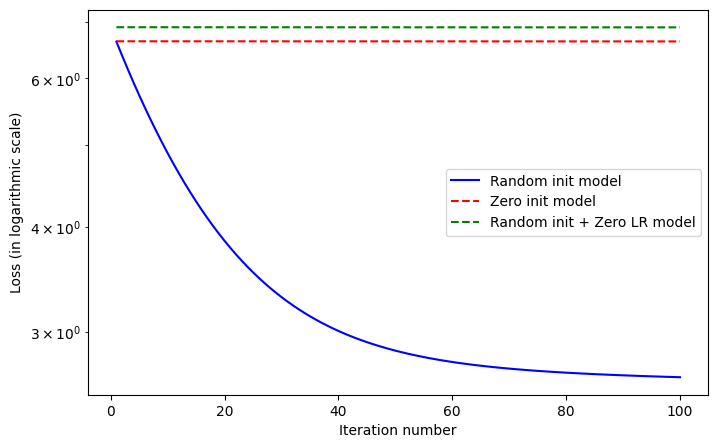

In [9]:
# Compare training curves
fig = plt.figure(figsize = (8, 5))
plt.plot(list(range(len(shallow_neural_net_normal.losses_list))), \
            shallow_neural_net_normal.losses_list, \
            "b", label = "Random init model")
plt.plot(list(range(len(shallow_neural_net_zero.losses_list))), \
            shallow_neural_net_zero.losses_list, \
            "r--", label = "Zero init model")
plt.plot(list(range(len(shallow_neural_net_normal_zerolr.losses_list))), \
            shallow_neural_net_normal_zerolr.losses_list, \
            "g--", label = "Random init + Zero LR model")
plt.xlabel("Iteration number")
plt.ylabel("Loss (in logarithmic scale)")
plt.yscale("log")
# Display
plt.legend(loc = "best")
plt.show()

### Controlling the vanishing gradient problem

The lessons to be learned here are threefold:
- The vanishing gradient problem, just like the exploding one, is a serious problem and can lead to a network being unable to train correctly. A typical telltale sign is a network stopping early with a loss value still very high. Or a network training at a very slow pace, or even training at all.
- A typical way to prevent the vanishing gradient problem consists of using a learning rate $ \alpha $ that is not too small, to prevent changes in the gradient descent rule from being much smaller than the parameters to be changed.
- And, more importantly, it is important to control the initiation of the network parameters. If the values of the initial parameters in the matrices $ W_1 $, $ b_1 $, $ W_2 $ and $ b_2 $ are way too small before training, then this could lead to a vanishing gradient problem. We show it below, by first running the random normal initialization, and then running it again, but dividing all elements in $ W_1 $, $ b_1 $, $ W_2 $ and $ b_2 $ by - say - a factor 1000. The second case will suddenly suffer from a vanishing gradient issue and be unable to train correctly!

In [10]:
# Define and train neural network structure (Normal initialization)
n_x = 2
n_h = 4
n_y = 1
init_type = "Normal"
np.random.seed(37)
shallow_neural_net_normal1 = ShallowNeuralNet(n_x, n_h, n_y, init_type)
# Train and show final loss
shallow_neural_net_normal1.train(inputs, outputs, N_max = 100, alpha = 1e-6, delta = 1e-6, display = True)
print(shallow_neural_net_normal1.loss)

- Gradients: 
[[ 1.42356523e-05 -1.73577846e-06 -9.53259136e-07  1.24839272e-06]
 [ 1.32743203e-04 -1.61856153e-05 -8.88885652e-06  1.16408890e-05]]
[[ 1.27309997e-07 -1.55231348e-08 -8.52503385e-09  1.11644251e-08]]
[[ 3.86686371e-04]
 [ 2.71147622e-04]
 [ 8.05690592e-05]
 [-1.49929229e-04]]
[[2.45019007e-06]]
- Parameters: 
[[-0.00544636  0.06743081  0.0346647  -0.13003462]
 [ 0.15185119  0.09898237  0.02776809 -0.04485894]]
[[ 0.09619662 -0.08275786  0.05346571  0.12283862]]
[[ 0.05195923]
 [-0.00633548]
 [-0.00347934]
 [ 0.00455655]]
[[0.14480251]]
- Gradients: 
[[ 1.33509060e-05 -1.71029927e-06 -9.21574694e-07  1.21839677e-06]
 [ 1.27650738e-04 -1.63525206e-05 -8.81136384e-06  1.16493403e-05]]
[[ 1.20261279e-07 -1.54059042e-08 -8.30129070e-09  1.09749821e-08]]
[[ 3.74339400e-04]
 [ 2.62301797e-04]
 [ 7.78514894e-05]
 [-1.44438980e-04]]
[[2.33188559e-06]]
- Parameters: 
[[-0.0054606   0.06743254  0.03466566 -0.13003587]
 [ 0.15171844  0.09899856  0.02777698 -0.04487058]]
[[ 0.09619

In [11]:
# Define and train neural network structure (Normal initialization)
n_x = 2
n_h = 4
n_y = 1
init_type = "Normal"
np.random.seed(37)
shallow_neural_net_normal2 = ShallowNeuralNet(n_x, n_h, n_y, init_type)
# Divide initial values by 1000!
shallow_neural_net_normal2.W1 /= 1000
shallow_neural_net_normal2.b1 /= 1000
shallow_neural_net_normal2.W2 /= 1000
shallow_neural_net_normal2.b2 /= 1000
# Train and show final loss
shallow_neural_net_normal2.train(inputs, outputs, N_max = 100, alpha = 1e-6, delta = 1e-6, display = True)
print(shallow_neural_net_normal2.loss)

- Gradients: 
[[-3.42224077e-08  4.17279915e-09  2.29162823e-09 -3.00112729e-09]
 [-1.30126212e-07  1.58665209e-08  8.71361545e-09 -1.14113924e-08]]
[[-2.57344163e-10  3.13784323e-11  1.72324856e-11 -2.25677455e-11]]
[[-3.77183931e-07]
 [-2.91893225e-07]
 [-9.26384914e-08]
 [ 1.97381842e-07]]
[[-4.95280908e-06]]
- Parameters: 
[[-5.44636123e-06  6.74308066e-05  3.46647026e-05 -1.30034617e-04]
 [ 1.51851188e-04  9.89823706e-05  2.77680897e-05 -4.48589354e-05]]
[[ 9.61966244e-05 -8.27578639e-05  5.34657065e-05  1.22838619e-04]]
[[ 5.19592333e-05]
 [-6.33548190e-06]
 [-3.47933573e-06]
 [ 4.55655471e-06]]
[[0.0001448]]
- Gradients: 
[[-3.44707716e-08  3.98053929e-09  2.23060869e-09 -2.87111843e-09]
 [-1.31070546e-07  1.51354737e-08  8.48159426e-09 -1.09170478e-08]]
[[-2.59211758e-10  2.99326803e-11  1.67736309e-11 -2.15901072e-11]]
[[-3.77531547e-07]
 [-2.91850126e-07]
 [-9.26149671e-08]
 [ 1.97350887e-07]]
[[-4.95279905e-06]]
- Parameters: 
[[-5.41213883e-06  6.74266338e-05  3.46624110e-0

In [12]:
print(shallow_neural_net_normal1.loss)
print(shallow_neural_net_normal2.loss)

2.654115820074732
6.637936966407209


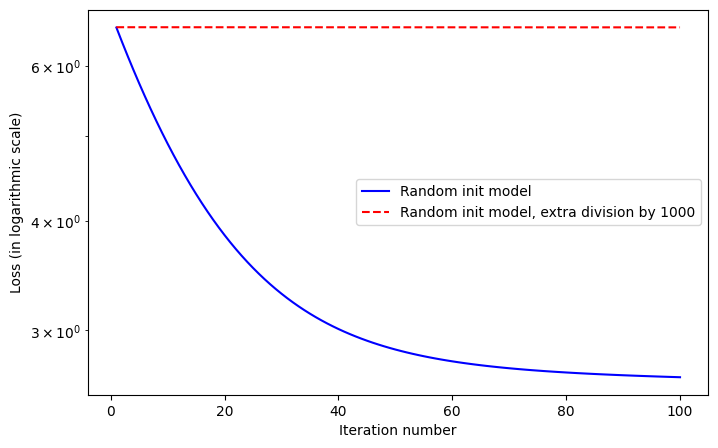

In [13]:
# Compare training curves
fig = plt.figure(figsize = (8, 5))
plt.plot(list(range(len(shallow_neural_net_normal1.losses_list))), \
            shallow_neural_net_normal1.losses_list, \
            "b", label = "Random init model")
plt.plot(list(range(len(shallow_neural_net_normal2.losses_list))), \
            shallow_neural_net_normal2.losses_list, \
            "r--", label = "Random init model, extra division by 1000")
plt.xlabel("Iteration number")
plt.ylabel("Loss (in logarithmic scale)")
plt.yscale("log")
# Display
plt.legend(loc = "best")
plt.show()

### What's next?

In the next notebook, we will investigate the impact of using activation functions in Neural Networks and implement them in our class.

This vanishing gradient problem is something we will explore again on Week 4, when discussing residuals and how they help address the vanishing gradient problem in large CNN architectures (to be discussed on Week 4).